In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import RidgeClassifierCV, SGDClassifier, PassiveAggressiveClassifier,Perceptron,LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
#import shap

In [ ]:
# 载入数据集
dataset = pd.read_csv("data/train_data_standardized.csv")
x_train = dataset[dataset.columns[1:]]
y_train = dataset[['dic']].values.ravel()

dataset_test = pd.read_csv("data/test_data_standardized.csv")
x_test = dataset_test[dataset_test.columns[1:]]
y_test = dataset_test[['dic']].values.ravel()

# 设定阈值，比如非重复值个数少于一定数量时认为是分类变量
threshold = 2 # 可根据实际需求调整

# 自动提取列名，根据唯一值数量
columns_by_unique_count = x_train.nunique()  # 每列的唯一值个数
categorical_cols = columns_by_unique_count[columns_by_unique_count <= threshold].index.tolist()
categorical_indices = [x_train.columns.get_loc(col) for col in categorical_cols] #获取分类变量索引，用于过采样
continuous_cols = columns_by_unique_count[columns_by_unique_count > threshold].index.tolist()
#print(categorical_cols)
#print(continuous_cols)

In [15]:
#feature_list = ['PCT', 'HB', 'LYM', 'CRE', 'PLT', 'DBIL', 'IBIL', 'EOS', 'MON', 'Cough'][0:5]
#len(feature_list)
# x_train = x_train[feature_list]
# x_test = x_test[feature_list]
# x_train.shape,x_test.shape

# 模型选择
注意调整超参数

In [ ]:
print('[1]ensemble\n[2]tree\n[3]linear\n[4]svm\n[5]bayes\n[6]neighbors\n[7]neural network')
leixing = input('请选择类型：')
if leixing == '1':
    print('[a]AdaBoost\n[b]RandomForest\n[c]GradientBoosting\n[d]ExtraTree\n[e]XGBoost')
    model_all = {'a':'AdaBoostClassifier(algorithm="SAMME.R", learning_rate= 0.1, n_estimators=448 ,random_state=1)', 
                 'b':'RandomForestClassifier(criterion= "gini", max_depth=8, max_features=0.1, n_estimators=99,random_state=1)', 
                 'c':'GradientBoostingClassifier(learning_rate= 0.2, max_depth=3, max_features=0.13, n_estimators=50, subsample=0.68, random_state=1)', 
                 'd':'ExtraTreesClassifier(criterion="gini", max_depth=11, max_features=0.06999999999999999,n_estimators=60, random_state=1)'} 
                 #'e':'XGBClassifier(max_depth=1,random_state=1,seed = 1)'}
elif leixing == '2':
    print('[a]DecisionTree\n[b]ExtraTree')
    model_all = {'a':'DecisionTreeClassifier(criterion="gini",max_depth=2 ,splitter="best", max_features=5,random_state=1)',  
                 'b':'ExtraTreeClassifier(criterion="gini", max_depth=10, max_features="sqrt", min_samples_leaf=5, min_samples_split=2, splitter="best", random_state=1)'} 
elif leixing == '3':
    print('[a]ElasticNet\n[b]Logistic\n[c]Ridge\n[d]SDG\n[e]Perceptron\n[f]PAC')
    model_all = {#'a':'ElasticNetCV(random_state = 1)', 
                'b':'LogisticRegression(fit_intercept=True, max_iter=2000, penalty="l1", solver="liblinear", random_state=1)',
                'c':'RidgeClassifierCV(alphas=38.2, fit_intercept=True)',#这个模型不能设置随机数种子,32
                'd':'SGDClassifier(alpha=0.06999999999999999, fit_intercept=False, l1_ratio=0.4, learning_rate="optimal", loss="epsilon_insensitive", penalty="elasticnet", random_state=1)',
                'e':'Perceptron(alpha=5.9999999999999995e-05, fit_intercept=True, penalty="l2",random_state=1)',
                'f':'PassiveAggressiveClassifier(C=0.001, fit_intercept=True, random_state = 1)'} 
elif leixing == '4':
    print('[a]LinearSVC\n[b]SVC\n[c]LDA')
    model_all = {'a': 'LinearSVC(C=0.01, dual=False, penalty="l2", random_state=1)', 
                 'b': 'SVC(C=147, gamma=0.0009000000000000001, kernel="poly", random_state=1)'} 
                 #'c':'LinearDiscriminantAnalysis(shrinkage="auto", solver="lsqr")'}
elif leixing == '5':
    print('[a]BernoulliNB\n[b]GaussianNB')
    model_all = {'a':'BernoulliNB(alpha=11.111111111111112, binarize=0.0,, class_prior=None, fit_prior=True)', # 无需random_state
                 'b':'GaussianNB(var_smoothing = 10.0)'} #无需random_state
elif leixing == '6':
    print('[a]KNN')
    model_all = {'a':'KNeighborsClassifier(metric="manhattan", n_neighbors=4, p= 1, weights="uniform")'} # 无需random_state

model_want = input('请选择模型:')
model_out = model_all.get(model_want)
print("model_out:",model_out)

model =eval(model_out)

smote = SMOTENC(categorical_features=categorical_indices, random_state=1) #过采样

# 构建 Pipeline，交叉验证时仅在训练集的 fold 内进行 SMOTENC，验证集不进行过采样
pipeline = Pipeline([
    ('smote', smote),  #只有训练的时候会启动 SMOTENC，预测的时候不会启动
    ('model', model)
]) 

pipeline.fit(x_train, y_train)

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
#scores = cross_val_score(pipeline, x_train, y_train, cv=cv, n_jobs=120, scoring='roc_auc', verbose=0)
#print('五折train_AUC:', scores.mean())
#scores_acc = cross_val_score(pipeline, x_train, y_train, cv=cv, n_jobs=120, scoring='accuracy', verbose=0)
#print('五折train_ACC:', scores_acc.mean())
scores_f1 = cross_val_score(pipeline, x_train, y_train, cv=cv, n_jobs=120, scoring='f1', verbose=0)
print('五折train_f1:', scores_f1.mean()) 

if hasattr(pipeline.named_steps["model"], 'decision_function'):
    y_pred_train = pipeline.decision_function(x_train)
    y_pred_test = pipeline.decision_function(x_test)
    # 根据阈值将预测结果转换为二进制标签
    y_pred_train_binary = (y_pred_train > 0).astype(int)
    y_pred_test_binary = (y_pred_test > 0).astype(int)
    
else:    
    y_pred_train = pipeline.predict_proba(x_train)[:, 1]
    y_pred_test = pipeline.predict_proba(x_test)[:, 1]
    # 选择默认阈值为0.5来转换预测概率为二进制标签
    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)

auc_train = roc_auc_score(y_train, y_pred_train)
acc_train = accuracy_score(y_train, model.predict(x_train))
f1_train = f1_score(y_train, y_pred_train_binary)

auc_test = roc_auc_score(y_test, y_pred_test)
acc_test = accuracy_score(y_test, model.predict(x_test))
f1_test = f1_score(y_test, y_pred_test_binary)

print('训练集AUC:', auc_train)
print('训练集ACC:', acc_train)
print('训练集F1分数:', f1_train)

print('测试集AUC:', auc_test)
print('测试集ACC:', acc_test)
print('测试集F1分数:', f1_test)

[1]ensemble
[2]tree
[3]linear
[4]svm
[5]bayes
[6]neighbors
[7]neural network


[a]DecisionTree
[b]ExtraTree
model_out: ExtraTreeClassifier(criterion="gini", max_depth=10, max_features="sqrt", min_samples_leaf=5, min_samples_split=2, splitter="best", random_state=1)
五折train_f1: 0.19336898922441126
训练集AUC: 0.9131602728849328
训练集ACC: 0.845061533606816
训练集F1分数: 0.3409395973154362
测试集AUC: 0.6997621329029873
测试集ACC: 0.8050473186119874
测试集F1分数: 0.20971867007672634


## 决策边界

In [6]:
from sklearn.decomposition import PCA  

In [ ]:
dataset = 'shap5特征'
# 合并两个数据集
X_high_dim_combined = np.vstack([x_train, x_test])
y_true_combined = np.hstack([y_train, y_test])

# 1. 使用PCA进行降维
pca = PCA(n_components=2)  # 创建PCA对象，将数据降到2维
X_low_dim_combined = pca.fit_transform(X_high_dim_combined)  # 使用PCA将高维数据降到2维

# 分别获取两个数据集在降维空间中的坐标
X_low_dim1 = pd.DataFrame(X_low_dim_combined[:len(x_train)])
X_low_dim2 = pd.DataFrame(X_low_dim_combined[len(x_train):])


# 2. 确定网格范围
margin = 1  # 设置边距大小，确保图形边界外留出一定空白
x_min, x_max = X_low_dim_combined[:, 0].min() - margin, X_low_dim_combined[:, 0].max() + margin  # 计算第一主成分的最小和最大值，并加上边距
y_min, y_max = X_low_dim_combined[:, 1].min() - margin, X_low_dim_combined[:, 1].max() + margin  # 计算第二主成分的最小和最大值，并加上边距

# 3. 创建低维网格点
grid_size = 2000  # 设置网格密度，即在每个维度上生成2000个网格点
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                     np.linspace(y_min, y_max, grid_size))  # 生成x和y轴上的网格点
grid_points_low_dim = np.c_[xx.ravel(), yy.ravel()]  # 将网格点展平成二维数组，用于后续计算

# 4. 逆映射网格点至高维空间
grid_points_high_dim = pca.inverse_transform(grid_points_low_dim)  # 使用PCA的逆变换将低维网格点映射回高维空间

# 5. 模型预测
predictions = pipeline.predict(grid_points_high_dim)  # 使用训练好的模型对高维空间中的网格点进行分类预测
Z = predictions.reshape(xx.shape)  # 将预测结果reshape为与网格形状相同，以便后续绘图

# 6. 绘制决策边界
num_classes = len(np.unique(y_true_combined))  # 获取数据集中类别的数量
plt.figure(figsize=(20, 12))
plt.contourf(xx, yy, Z, levels=np.arange(num_classes + 1) - 0.5, cmap=plt.cm.Paired, alpha=0.8)  


# 使用contourf绘制决策边界，采用不同颜色填充每个类别的区域
# 绘制原始数据点
# 定义颜色，分别对应类别 0 和 1
colors_train = ['red', 'yellow']  # 训练集类别 0 用红色，类别 1 用蓝色
colors_zheyi = ['blue', 'white']  # 验证集类别 0 用绿色，类别 1 用紫色

# 绘制训练集类别 0 和 1
scatter_train_0 = plt.scatter(X_low_dim1.iloc[y_train == 0, 0],
                              X_low_dim1.iloc[y_train == 0, 1],
                              color=colors_train[0], edgecolor='k', s=50, label='Train - Class 0')  # 点的大小 s=20

scatter_train_1 = plt.scatter(X_low_dim1.iloc[y_train == 1, 0],
                              X_low_dim1.iloc[y_train == 1, 1],
                              color=colors_train[1], edgecolor='k', s=50, label='Train - Class 1')

# 绘制验证集类别 0 和 1
scatter_test_0 = plt.scatter(X_low_dim2.iloc[y_test == 0, 0],
                              X_low_dim2.iloc[y_test == 0, 1],
                              color=colors_zheyi[0], edgecolor='k', marker='x', s=60, label='Test - Class 0')

scatter_test_1 = plt.scatter(X_low_dim2.iloc[y_test == 1, 0],
                              X_low_dim2.iloc[y_test == 1, 1],
                              color=colors_zheyi[1], edgecolor='k', marker='x', s=60, label='Test - Class 1')

# 绘制降维后的数据点，使用不同颜色表示不同类别
# 添加图形元素
plt.xlabel('Principal Component 1')  # 设置x轴标签为"第一主成分"
plt.ylabel('Principal Component 2')  # 设置y轴标签为"第二主成分"

#model_name = type(model).__name__  # 获取模型类名
plt.title(f'{dataset} Decision Boundary in Low-dimensional Space')  # 设置图形标题为"低维空间中的决策边界"
plt.legend()  # 确保图例显示
plt.savefig(f'决策边界（十六支队）/{dataset}_decision_boundary.png', dpi=300)  # 保存图像

plt.show()  # 显示绘制的图形
#保存数据
#model_name = type(model).__name__  # 获取模型类名
# 保存 predictions
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
predictions_df.to_csv(f'决策边界（十六支队）/{dataset}_predictions.csv', index=False)

# 保存X_low_dim1 和 X_low_dim2

X_low_dim_combined = pd.DataFrame(X_low_dim_combined)
X_low_dim1.to_csv(f'决策边界（十六支队）/{dataset}_X_low_dim_train.csv', index=False)
X_low_dim2.to_csv(f'决策边界（十六支队）/{dataset}_X_low_dim_test.csv', index=False)

# shap

In [ ]:
import shap
import pickle

In [ ]:
#model.fit(x_train, y_train.values.ravel().astype('int'))
explainer = shap.Explainer(pipeline.predict,x_train, random_state=1)
shap_values = explainer(x_train) 

In [162]:
# 将 SHAP 值保存到文件
with open('./十六支队shap结果/SGDClassifier/shap_values.pkl', 'wb') as f: #修改名称
    pickle.dump(shap_values, f)

In [ ]:
# 从文件中读取 SHAP 值
with open('./十六支队shap结果/SGDClassifier/shap_values.pkl', 'rb') as f: # 修改名称
    shap_values = pickle.load(f)

In [163]:
shap_values_array = shap_values.values  # 取出 SHAP 值数组
feature_names = x_train.columns  # 特征名称，假设 x_train 是 pandas DataFrame

# 将 SHAP 值数组转换为 DataFrame
shap_df = pd.DataFrame(shap_values_array, columns=feature_names)

# 如果需要，也可以保存为 Excel 文件
shap_df.to_excel('./十六支队shap结果/SGDClassifier/shap_values.xlsx', index=False)

## bar plot

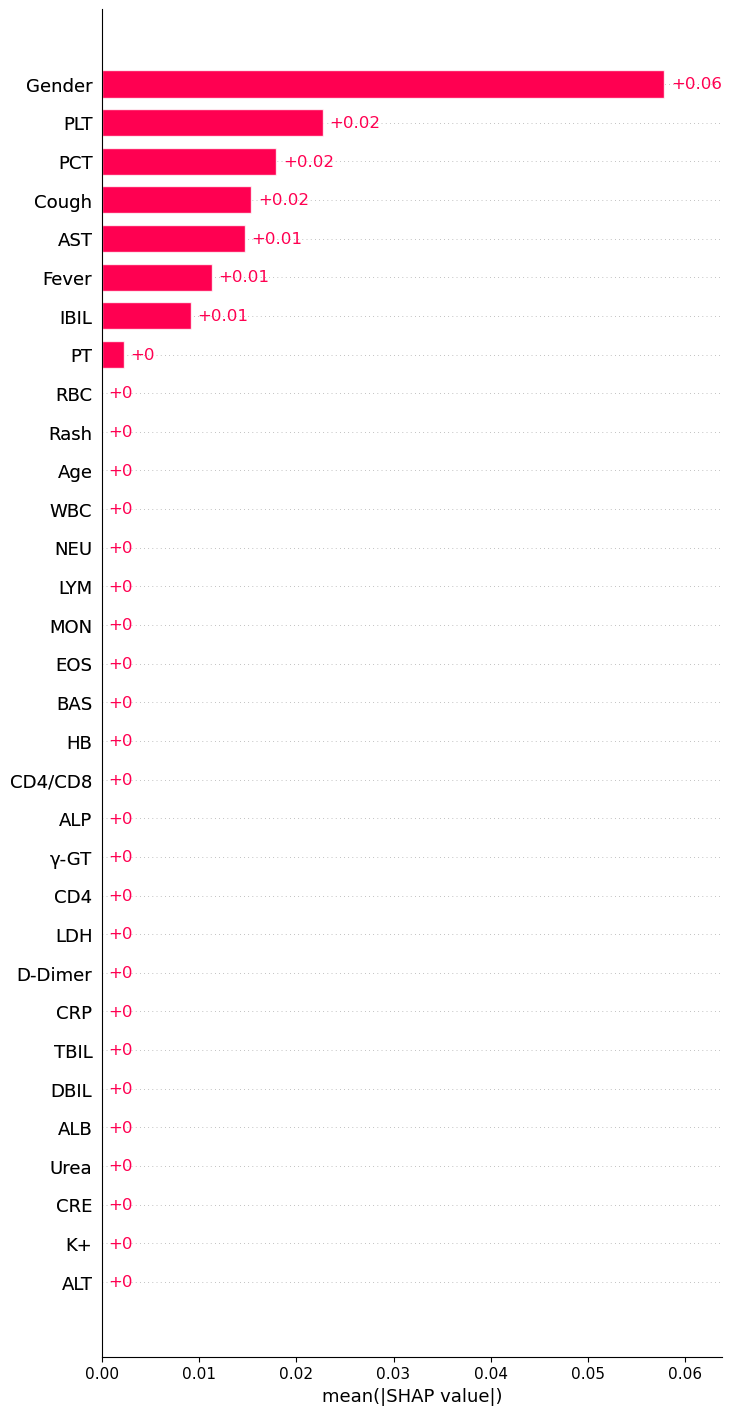

In [164]:
shap.plots.bar(shap_values, max_display=32, show=False)#max_display代表图表最大输出多少个项目
#plt.savefig('./十六支队shap结果/SVC/bar_plot.png', dpi=300)
#plt.savefig('./十六支队shap结果/AdaBoostClassifier/bar_plot.svg')
plt.show()

In [165]:
# 计算每个特征的绝对 SHAP 值的均值
shap_values_abs_mean = np.abs(shap_values.values).mean(axis=0)

# 获取特征名称
feature_names = x_train.columns

# 创建 DataFrame 来保存 SHAP 重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': shap_values_abs_mean
})

# 按 SHAP 重要性排序
rank_df = importance_df
rank_df["rank"] = rank_df['SHAP Importance'].rank(ascending=False)

importance_df = importance_df.sort_values(by='SHAP Importance', ascending=False)
importance_df
# 保存 SHAP 重要性到 Excel 文件
rank_df.to_excel('./十六支队shap结果/SGDClassifier/shap_rank.xlsx', index=False)
importance_df.to_excel('./十六支队shap结果/SGDClassifier/shap_importance_abs_mean.xlsx', index=False)

In [166]:
importance_df['Feature'].tolist()[0:10]

['Gender', 'PLT', 'PCT', 'Cough', 'AST', 'Fever', 'IBIL', 'PT', 'Rash', 'CRP']

In [44]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': shap_values_abs_mean
})
importance_df

,Feature,SHAP Importance
0,Gender,0.000740
1,Fever,0.000138
2,Cough,0.001626
3,Rash,0.000810
4,Age,0.000462
5,WBC,0.001874
6,NEU,0.001855
7,LYM,0.000695
8,MON,0.000233
9,EOS,0.000681


# permutation

In [ ]:
f1_scorer = make_scorer(f1_score, average='binary')
result = permutation_importance(pipeline, x_train, y_train, n_repeats=10,random_state=1, scoring=f1_scorer)
output = pd.DataFrame({'feature_name':x_train.columns.tolist(),'importances_mean':result['importances_mean']})
#pd.options.display.float_format = '{:.4f}'.format
output = output.sort_values(by='importances_mean', ascending=False)
#output.to_csv(r"C:\Users\15088\Desktop\循环结果.csv", header=1, index=0)
output

,feature_name,importances_mean
6,NEU,0.087500
5,WBC,0.087270
15,AST,0.035748
21,DBIL,0.032089
17,LDH,0.024461
20,TBIL,0.023638
31,PCT,0.022242
7,LYM,0.016151
28,CD4/CD8,0.007429
23,ALB,0.006164


In [81]:
print(output['feature_name'].tolist()[0:10])

['NEU', 'WBC', 'AST', 'DBIL', 'LDH', 'TBIL', 'PCT', 'LYM', 'CD4/CD8', 'ALB']


In [82]:
output = output.sort_values(by='importances_mean', ascending=False)
output.to_excel('./十六支队permutation结果/SVC/permutation_importance.xlsx', index=False)

# PR曲线

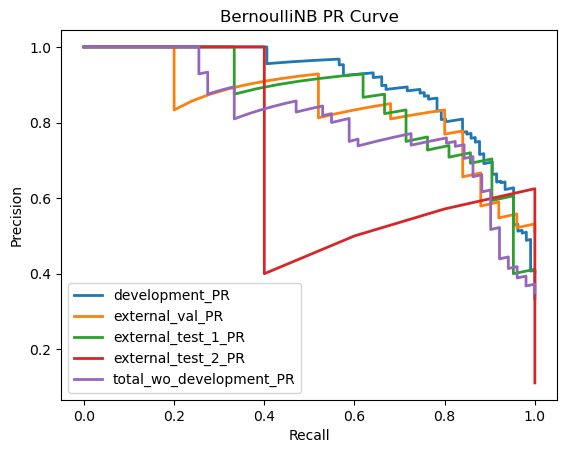

In [39]:
# 计算 Precision-Recall 曲线及其对应的阈值）
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred)
precision_test_1, recall_test_1, thresholds_test_1 = precision_recall_curve(y_test_1, y_pred_1)
#precision_test_2, recall_test_2, thresholds_test_2 = precision_recall_curve(y_test_2, y_pred_2)
#precision_test_3, recall_test_3, thresholds_test_3 = precision_recall_curve(y_test_3, y_pred_3)
#precision_test_5, recall_test_5, thresholds_test_5 = precision_recall_curve(y_test_5, y_pred_5)

# 绘制PR曲线函数
def plot_pr_curve(precision, recall, label):
    plt.plot(recall, precision, lw=2, label=label)

# 绘制PR曲线
plt.figure()
plot_pr_curve(precision_train, recall_train, 'development_PR')
plot_pr_curve(precision_test_2, recall_test_2, 'external_val_PR')
#plot_pr_curve(precision_test_3, recall_test_3, 'external_test_1_PR')
#plot_pr_curve(precision_test_1, recall_test_1, 'external_test_2_PR')
#plot_pr_curve(precision_test_5, recall_test_5, 'total_wo_development_PR')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('BernoulliNB PR Curve') #修改名称
plt.legend(loc="lower left")

# 保存图像到文件夹
plt.savefig('./output/PR曲线及其数据/图片/BernoulliNB.png') #修改名称
plt.show()

# 将 Precision、Recall 和阈值保存为 Excel
pr_data_train = pd.DataFrame({
    #'Threshold': np.append(thresholds_train, 1),  # thresholds 数量少一个，补齐
    'Precision': precision_train,
    'Recall': recall_train
})

pr_data_test_1 = pd.DataFrame({
    #'Threshold': np.append(thresholds_test_1, 1),
    'Precision': precision_test_1,
    'Recall': recall_test_1
})

pr_data_test_2 = pd.DataFrame({
    #'Threshold': np.append(thresholds_test_2, 1),
    'Precision': precision_test_2,
    'Recall': recall_test_2
})

pr_data_test_3 = pd.DataFrame({
   # 'Threshold': np.append(thresholds_test_3, 1),
    'Precision': precision_test_3,
    'Recall': recall_test_3
})

pr_data_test_5 = pd.DataFrame({
    #'Threshold': np.append(thresholds_test_5, 1),
    'Precision': precision_test_5,
    'Recall': recall_test_5
})

# 将不同数据集的 PR 曲线坐标保存到 Excel 文件的不同 sheet
with pd.ExcelWriter('./output/PR曲线及其数据/数据/BernoulliNB.xlsx') as writer: #修改名称
    pr_data_train.to_excel(writer, sheet_name='development_PR', index=False)
    pr_data_test_2.to_excel(writer, sheet_name='external_val_PR', index=False)
    pr_data_test_3.to_excel(writer, sheet_name='external_test_1_PR', index=False)
    pr_data_test_1.to_excel(writer, sheet_name='external_test_2_PR', index=False)
    pr_data_test_5.to_excel(writer, sheet_name='total_wo_development_PR', index=False)


# ROC曲线

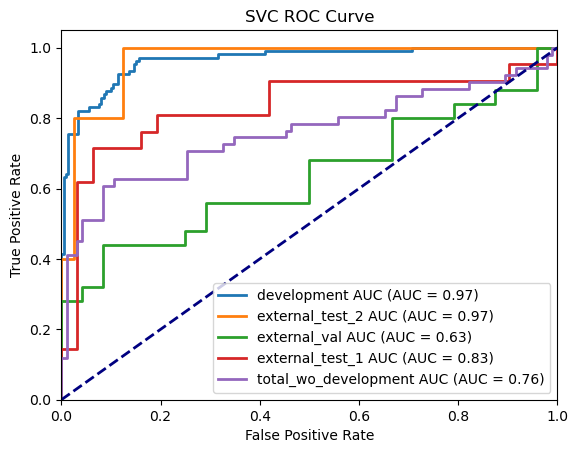

In [29]:
# 绘制ROC曲线函数
def plot_roc_curve(fpr, tpr, roc_auc, label):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# 计算ROC曲线和AUC
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred)
fpr_test_1, tpr_test_1, _ = roc_curve(y_test_1, y_pred_1)
fpr_test_2, tpr_test_2, _ = roc_curve(y_test_2, y_pred_2)
fpr_test_3, tpr_test_3, _ = roc_curve(y_test_3, y_pred_3)
fpr_test_5, tpr_test_5, _ = roc_curve(y_test_5, y_pred_5)

# 保存ROC坐标到Excel
df_roc_train = pd.DataFrame({'FPR': fpr_train, 'TPR': tpr_train})
df_roc_test_1 = pd.DataFrame({'FPR': fpr_test_1, 'TPR': tpr_test_1})
df_roc_test_2 = pd.DataFrame({'FPR': fpr_test_2, 'TPR': tpr_test_2})
df_roc_test_3 = pd.DataFrame({'FPR': fpr_test_3, 'TPR': tpr_test_3})
df_roc_test_5 = pd.DataFrame({'FPR': fpr_test_5, 'TPR': tpr_test_5})

with pd.ExcelWriter('./output/ROC曲线及其坐标/坐标/SVC.xlsx') as writer: #修改文件名
    df_roc_train.to_excel(writer, sheet_name='development_ROC', index=False)
    df_roc_test_1.to_excel(writer, sheet_name='external_test_2_ROC', index=False)
    df_roc_test_2.to_excel(writer, sheet_name='external_val_ROC', index=False)
    df_roc_test_3.to_excel(writer, sheet_name='external_test_1_ROC', index=False)
    df_roc_test_5.to_excel(writer, sheet_name='total_wo_development_ROC', index=False)

# 绘制ROC曲线
plt.figure()
plot_roc_curve(fpr_train, tpr_train, auc_train, 'development AUC')
plot_roc_curve(fpr_test_1, tpr_test_1, auc_1, 'external_test_2 AUC')
plot_roc_curve(fpr_test_2, tpr_test_2, auc_2, 'external_val AUC')
plot_roc_curve(fpr_test_3, tpr_test_3, auc_3, 'external_test_1 AUC')
plot_roc_curve(fpr_test_5, tpr_test_5, auc_5, 'total_wo_development AUC')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve')  # 修改标题
plt.legend(loc="lower right")

# 保存图像到output文件夹

plt.savefig(os.path.join('./output/ROC曲线及其坐标/图片', 'SVC.png'))  # 修改文件名

# 显示图像
plt.show()

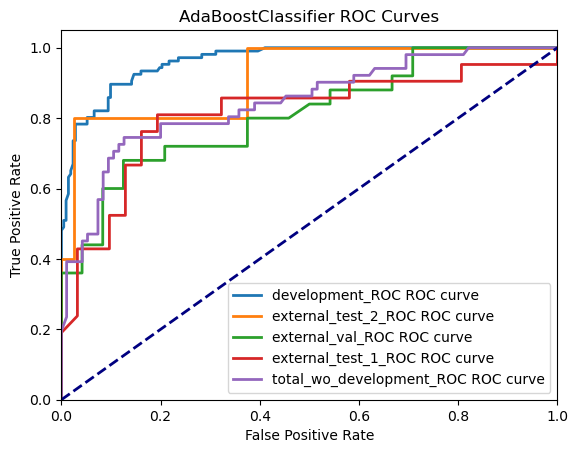

In [9]:
# Excel文件路径
file_path = './output/ROC曲线及其坐标/坐标/AdaBoostClassifier.xlsx'  # 替换为你的Excel文件路径

# 获取所有sheet的名称
sheets = pd.ExcelFile(file_path).sheet_names

# 创建绘图
plt.figure()

# 遍历每个Sheet，读取FPR和TPR并绘制ROC曲线
for sheet_name in sheets:
    # 读取每个Sheet的数据
    roc_data = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # 假设FPR在第一列，TPR在第二列
    fpr = roc_data.iloc[:, 0]
    tpr = roc_data.iloc[:, 1]
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, lw=2, label=f'{sheet_name} ROC curve')

# 添加对角线（参考线）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设置坐标轴范围
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# 添加标签和标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoostClassifier ROC Curves')

# 显示图例
plt.legend(loc="lower right")

# 显示图像
plt.show()


In [2]:
random_num = 1
data = "./归一化后的数据/对数归一化后的数据（十七支队）.xlsx"
data_test = "./归一化后的数据/对数归一化后的数据（十七支队）.xlsx"
#模型选择
print('[1]ensemble\n[2]tree\n[3]linear\n[4]svm\n[5]bayes\n[6]logistic\n[7]neural network\n[8]neighbor')
leixing = input('请选择类型：')
if leixing == '1':
    print('[a]AdaBoost\n[b]RandomForest\n[c]GradientBoosting\n[d]ExtraTree\n[e]XGBoost')
    model_all = {'a':'AdaBoostClassifier(algorithm="SAMME", learning_rate=0.18999999999999995, random_state=1, n_estimators=410)', #调参后
                 'b':'RandomForestClassifier(criterion= "entropy", max_depth=7, max_features=0.1, n_estimators=96,random_state=1)', #调参后
                 'c':'GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features=0.11, n_estimators=90, subsample=0.8, random_state=1)',#调参
                 'd':'ExtraTreesClassifier(criterion="gini", max_depth=6, max_features=0.06999999,n_estimators=99, random_state=1)'} #调参后，两种模型，选效果好的
                 #'e':'XGBClassifier(max_depth=1,random_state=1,seed = 1)'}
elif leixing == '2':
    print('[a]DecisionTree\n[b]ExtraTree')
    model_all = {'a':'DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=4, max_features=4,random_state=1)',  #调参后
                 'b':'ExtraTreeClassifier(criterion="entropy", max_depth=4, max_features=3,splitter="best",random_state=1)'}
elif leixing == '3':
    print('[a]ElasticNet\n[b]LASSO\n[c]Ridge\n[d]SDG\n[e]感知机\n[f]PAC')
    model_all = {#'a': 'ElasticNetCV(random_state = random_num)', 
                 #'b': 'LassoCV(random_state = random_num)',
                'c':'RidgeClassifierCV(alphas=39.30000000000002, fit_intercept=True)',#这个模型不能设置随机数种子，调参后
                'd':'SGDClassifier(alpha=0.05, fit_intercept=True, l1_ratio=0.30000000000000004, learning_rate="optimal", loss="hinge", penalty="elasticnet", random_state=1)',#调参后
                'e':'Perceptron(alpha=3e-5, fit_intercept=True, penalty="elasticnet",random_state=1)', #调参后
                'f':'PassiveAggressiveClassifier(C=0.003, fit_intercept=True, random_state = 1)'} #调参后
elif leixing == '4':
    print('[a]LinearSVC\n[b]SVC\n[c]LDA')
    model_all = {'a': 'LinearSVC(C=0.09, dual=False, penalty="l1", random_state=1)', #调参后
                 'b': 'SVC(C=115, gamma=0.0002, kernel="rbf", random_state=1)'} #调参后
                 #'c':'LinearDiscriminantAnalysis(shrinkage="auto", solver="lsqr")'}
elif leixing == '5':
    print('[a]BernoulliNB')
    model_all = {'a':'BernoulliNB(alpha=0.0, binarize=0.7070707070707071, class_prior=None, fit_prior=True)'}#这个模型不能设置随机数种子，调参后
    
model_want = input('请选择模型:')
model_out = model_all.get(model_want)
print("model_out:",model_out)

# 载入数据集
excelFile = data
dataset = pd.DataFrame(pd.read_excel(excelFile,sheet_name="训练集"))
x_train = dataset[dataset.columns[1:]]
y_train = dataset[['Group']]
excelFile_test = data_test
dataset_test_1 = pd.DataFrame(pd.read_excel(excelFile_test, sheet_name="留出集"))
x_test_1 = dataset_test_1[dataset_test_1.columns[1:]]
y_test_1 = dataset_test_1[['Group']]
dataset_test_2 = pd.DataFrame(pd.read_excel(excelFile_test, sheet_name="西溪验证集"))
x_test_2 = dataset_test_2[dataset_test_2.columns[1:]]
y_test_2 = dataset_test_2[['Group']]
dataset_test_3 = pd.DataFrame(pd.read_excel(excelFile_test, sheet_name="浙一验证集"))
x_test_3 = dataset_test_3[dataset_test_3.columns[1:]]
y_test_3 = dataset_test_3[['Group']]

dataset_test_4 = pd.DataFrame(pd.read_excel(excelFile_test, sheet_name="全体数据集"))
x_test_4 = dataset_test_4[dataset_test_4.columns[1:]]
y_test_4 = dataset_test_4[['Group']]
dataset_test_5 = pd.DataFrame(pd.read_excel(excelFile_test, sheet_name="全体数据集without训练集"))
x_test_5 = dataset_test_5[dataset_test_5.columns[1:]]
y_test_5 = dataset_test_5[['Group']]
dataset_test_6 = pd.DataFrame(pd.read_excel(excelFile_test, sheet_name="浙一留出"))
x_test_6 = dataset_test_6[dataset_test_6.columns[1:]]
y_test_6 = dataset_test_6[['Group']]



model =eval(model_out)
# model = CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=5)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
model.fit(x_train, y_train.values.ravel())
# scores = cross_val_score(model, x_train, y_train.values.ravel(), cv=cv, n_jobs=-1, scoring='roc_auc', verbose=2)
scores = cross_val_score(model, x_train, y_train, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10), n_jobs=-1, scoring='roc_auc', verbose=1)
print('五折train_AUC:', scores.mean())
scores_acc = cross_val_score(model, x_train, y_train.values.ravel(), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10), n_jobs=-1, scoring='accuracy', verbose=1)
print('五折train_ACC:', scores_acc.mean())

if leixing == '3' or leixing == '4':
    y_pred = model.decision_function(x_train)
    y_pred_1 = model.decision_function(x_test_1)
    y_pred_2 = model.decision_function(x_test_2)
    y_pred_3 = model.decision_function(x_test_3)
    y_pred_4 = model.decision_function(x_test_4)
    y_pred_5 = model.decision_function(x_test_5)
    y_pred_6 = model.decision_function(x_test_6)

else:    
    y_pred = model.predict_proba(x_train)[:, 1]
    y_pred_1 = model.predict_proba(x_test_1)[:, 1]
    y_pred_2 = model.predict_proba(x_test_2)[:, 1]
    y_pred_3 = model.predict_proba(x_test_3)[:, 1]
    y_pred_4 = model.predict_proba(x_test_4)[:, 1]
    y_pred_5 = model.predict_proba(x_test_5)[:, 1]
    y_pred_6 = model.predict_proba(x_test_6)[:, 1]

auc_train = roc_auc_score(y_train, y_pred)
auc_1 = roc_auc_score(y_test_1, y_pred_1)
auc_2 = roc_auc_score(y_test_2, y_pred_2)
auc_3 = roc_auc_score(y_test_3, y_pred_3)
auc_4 = roc_auc_score(y_test_4, y_pred_4)
auc_5 = roc_auc_score(y_test_5, y_pred_5)
auc_6 = roc_auc_score(y_test_6, y_pred_6)


print('训练集AUC:', auc_train)
print('留出集AUC:', auc_1)
print('西溪验证集AUC:', auc_2)
print('浙一验证集AUC:', auc_3)
print('全体数据集AUC:', auc_4)
print('全体数据集without训练集AUC:', auc_5)
print('浙一留出AUC:', auc_6)


acc_train = accuracy_score(y_train, model.predict(x_train))
acc_1 = accuracy_score(y_test_1, model.predict(x_test_1))
acc_2 = accuracy_score(y_test_2, model.predict(x_test_2))
acc_3 = accuracy_score(y_test_3, model.predict(x_test_3))
acc_4 = accuracy_score(y_test_4, model.predict(x_test_4))
acc_5 = accuracy_score(y_test_5, model.predict(x_test_5))
acc_6 = accuracy_score(y_test_6, model.predict(x_test_6))


print('训练集ACC:', acc_train)
print('留出集ACC:', acc_1)
print('西溪验证集ACC:', acc_2)
print('浙一验证集ACC:', acc_3)
print('全体数据集ACC:', acc_4)
print('全体数据集without训练集ACC:', acc_5)
print('浙一留出ACC:', acc_6)

[1]ensemble
[2]tree
[3]linear
[4]svm
[5]bayes
[6]logistic
[7]neural network
[8]neighbor


请选择类型： 1


[a]AdaBoost
[b]RandomForest
[c]GradientBoosting
[d]ExtraTree
[e]XGBoost


请选择模型: a


model_out: AdaBoostClassifier(algorithm="SAMME", learning_rate=0.18999999999999995, random_state=1, n_estimators=410)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/louhao/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/louhao/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/louhao/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/louhao/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConve

五折train_AUC: 0.9368856816863462


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.7s finished


五折train_ACC: 0.8723313492063491
训练集AUC: 0.9883855464578142
留出集AUC: 0.9299999999999999
西溪验证集AUC: 0.82
浙一验证集AUC: 0.8264208909370199
全体数据集AUC: 0.9469491068279425
全体数据集without训练集AUC: 0.8565531475748194
浙一留出AUC: 0.880281690140845
训练集ACC: 0.9528301886792453
留出集ACC: 0.8888888888888888
西溪验证集ACC: 0.7346938775510204
浙一验证集ACC: 0.7692307692307693
全体数据集ACC: 0.9030172413793104
全体数据集without训练集ACC: 0.7945205479452054
浙一留出ACC: 0.8247422680412371


# 特征筛选结果可视化

In [ ]:
import seaborn as sns

In [ ]:
# 热图
plt.figure(dpi=300)
sns.heatmap(data=df,#矩阵数据集，数据的index和columns分别为heatmap的y轴方向和x轴方向标签               
         )
plt.title('32 features、12 models shap values heatmap')